# COGS 108 - Assignment 3: Data Analysis

This assignment covers extensive data cleaning, EDA, and regression.

This assignment is out of 8 points, worth 8% of your grade.

**PLEASE DO NOT CHANGE THE NAME OF THIS FILE.**

**PLEASE DO NOT COPY & PASTE OR DELETE CELLS INLCUDED IN THE ASSIGNMENT.

# Important Reminders

- This assignment has hidden tests: tests that are not visible here, but that will be run on your submitted assignment for grading.
    - This means passing all the tests you can see in the notebook here does not guarantee you have the right answer!
    - In particular many of the tests you can see simply check that the right variable names exist. Hidden tests check the actual values. 
        - It is up to you to check the values, and make sure they seem reasonable.
- A reminder to restart the kernel and re-run the code as a first line check if things seem to go weird.
    - For example, note that some cells can only be run once, because they re-write a variable (for example, your dataframe), and change it in a way that means a second execution will fail. 
    - Also, running some cells out of order might change the dataframe in ways that may cause an error, which can be fixed by re-running.

Run the following cell. These are all you need for the assignment. Do not import additional packages.

In [1]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

## Setup

Data: the responses collected from a previous survery of the COGS 108 class. 
- There are 416 observations in the data, covering 10 different 'features'.

Research Question: Do students in different majors have different heights?

Background: Physical height has previously shown to correlate with career choice, and career success. More recently it has been demonstrated that these correlations can actually be explained by height in high school, as opposed to height in adulthood (1). It is currently unclear whether height correlates with choice of major in university. 

Reference: 1) https://www.sas.upenn.edu/~apostlew/paper/pdf/short.pdf

Hypothesis: We hypothesize that there will be a relation between height and chosen major. 

## Part 1: Load & Clean the Data (2.5 points)


Fixing messy data makes up a large amount of the work of being a Data Scientist. 

The real world produces messy measurements and it is your job to find ways to standardize your data such that you can make useful analyses out of it. 

In this section, you will learn, and practice, how to successfully deal with unclean data.

### 1a) Load the data
Import datafile `COGS108_IntroQuestionnaireData.csv` into a DataFrame called `df`.

In [2]:
# your code here
df = pd.read_csv('COGS108_IntroQuestionnaireData.csv')
df.shape


(416, 10)

In [3]:
assert isinstance(df, pd.DataFrame)

In [4]:
#Check out the data
df.head(5)

,Timestamp,What year (in school) are you?,What is your major?,How old are you?,What is your gender?,What is your height?,What is your weight?,What is your eye color?,Were you born in California?,What is your favorite flavor of ice cream?
0,1/9/18 14:49,4,Cognitive Science,21.0,Male,"5'8""",147,Brown,Yes,Vanilla
1,1/9/18 14:49,3,Cognitive Science,20.0,Male,5'8,150,Brown,Yes,Cookies and Cream
2,1/9/18 14:49,Third,Computer Science,21.0,Male,181cm,74kg,Black,Yes,Matcha
3,1/9/18 14:49,2,Cogs HCI,20.0,Male,5’8,133,Brown,Yes,Cookies and Cream
4,1/9/18 14:49,3,Computer Science,20.0,Male,"5'10""",160,Brown,Yes,Cookies n' Cream


Those column names are a bit excessive, so first let's rename them - code provided below to do so. 

In [5]:
# Renaming the columns of the dataframe
df.columns = ['timestamp', 'year', 'major', 'age', 'gender', 'height',
              'weight', 'eye_color', 'born_in_CA', 'favorite_icecream']

`pandas` has a very useful function for detecting missing data. This function is called `isnull()`. 

If you have a dataframe called `df`, then calling `df.isnull()` will return another dataframe of the same size as `df` where every cell is either True of False. 

Each True or False is the answer to the question 'is the data in this cell null?'. So, False, means the cell is not null (and therefore, does have data). True means the cell is null (does not have data).

This function is very useful because it allows us to find missing data very quickly in our dataframe. As an example, consider the code below.

In [6]:
# Check the first few rows of the 'isnull' dataframe
df.isnull().head(5)

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


If you print out more, and scroll down, you'll see some rows with missing data. 

In [7]:
# For example:
df.isnull().iloc[48:50, :]

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
48,False,False,False,False,False,False,False,False,False,False
49,False,True,False,False,False,True,True,False,False,False


 Check an example, row 49, in which an entry has missing data:

In [8]:
df.iloc[49, :]

timestamp            1/9/18 14:50
year                          NaN
major                     Cog Sci
age                          21.0
gender                     Female
height                        NaN
weight                        NaN
eye_color                   Brown
born_in_CA                    Yes
favorite_icecream       Chocolate
Name: 49, dtype: object

Granted, the example above is not very informative. As you can see, the output of `isnull()` is a dataframe where the values at each cell is either True or False. Most cells have the value of `False`. We expect this to be the case since most people gave out answers to each question in our survey. 

However, some rows such as row 49 show that some people chose not to answer certain questions. In the case of row 49, it seems that someone did not give out an answer for 'What year (in school) are you?'

However, what if we wanted to use `isnull()` to see all rows where our dataframe `df` has missing values? In other words, what if we want to see the ACTUAL rows with missing values instead of this dataframe with True or False cells. For that, we need to write the following line of code:
<br>
<br>
`df[df.isnull().any(axis=1)]`

### 1b) Find missing data
Find all rows that have missing data in them.

Save the ouput, as a dataframe, into a variable called `rows_to_drop`.

In other words, copy over and use the line of code that we gave out in the cell above.

In [9]:
# your code here
rows_to_drop = df[df.isnull().any(axis=1)]

In [10]:
# check output
rows_to_drop.shape

(31, 10)

In [11]:
assert isinstance(rows_to_drop, pd.DataFrame)
assert rows_to_drop.shape == (31, 10)

In the cell below, briefly explain below how `df[df.isnull().any(axis=1)]` works, in a couple sentences. 

Include an explanation of what `any(axis=1)` means and how it affects the code.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.all.html

so using isnull() is used to check for missing data in the dataframe. so df.isnull() does this. The .any() checks to ensure that there is a value, that is non zero. If it is zero then it is false; otherwise true. The reason axis = 1 is because this parameter reduces the columns that were deleted. That is, as one can note, the original df had 416 columns and now has 31, the reduced version. Thus, any(axis=1) affects the code by checking the values and reducing the columns of the dataframe.

Run the following cell and look at its output, but you don't need to add any code here.

Real world data are messy. As an example of it, we consider the data shown in `rows_to_drop` (below).

If you've done everything correctly so far, you should see an unexpected response with emojis at index 357. These types of responses, although funny, are hard to parse when dealing with big datasets. 

We'll learn about solutions to these types of problems in the upcoming cells.

In [12]:
rows_to_drop

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
21,1/9/18 14:49,1,Cse,16.0,Male,184cm,78kg,Black,No,NaN
29,1/9/18 14:50,senior,math&econ,20.0,female,170,130,black,No,NaN
38,1/9/18 14:50,3rd,Computer Engineering,21.0,Female,NaN,NaN,Brown,No,NaN
49,1/9/18 14:50,NaN,Cog Sci,21.0,Female,NaN,NaN,Brown,Yes,Chocolate
58,1/9/18 14:50,3rd,Computer Science,20.0,Female,5ft 2in,NaN,brown,No,cookies and cream
66,1/9/18 14:50,Sophomore,Cognitive Science - Design and Interaction,19.0,Female,5'5,NaN,Brown,No,Chubby hubby ben and jerrys
67,1/9/18 14:50,2,Computer Science,19.0,Male,NaN,170,Brown,Yes,Chocolate
83,1/9/18 14:50,Senior,Computer Science,22.0,Male,5'11,155 lb,dark brown,No,NaN
91,1/9/18 14:50,Third,Computer Science,21.0,Female,NaN,NaN,Black,No,Green tea
92,1/9/18 14:50,4,Computer Science,21.0,Female,"5'5""",NaN,Brown,Yes,Mint chip


### 1c) Drop the rows with NaN values

Drop any rows with missing data, but only for the columns `major`, `height`, `gender` and `age`. These will be the data of primary interest for our analyses, so we drop missing data here. 

Note that there are other missing data (in other rows) but this is fine for our analyses, so we keep them. 

To do this, use the pandas `dropna` method, inplace, using the `subset` arguments to specify columns.

In [13]:
# your code here
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
df = df.dropna(subset=['major', 'height', 'gender', 'age']) #how = 'any', inplace = True)
df.shape

(403, 10)

In [14]:
assert df.shape == (403, 10)

In the rest of Part 1, we will work on writing code, organized into functions that will allow us to transform similar respones into the same value. We will call this process: standardizing the data. 

The cell below provides an example for the kind of code you will need to write to answer this question. This example is separate from our actual data, and is a potential function we might use to standardize messy data - in this case, hypothetical data to the question 'What is your favourite major python version?'. 

Note some things used in this example that you need to use to standardize data:
- string methods, such as `lower` and `strip` to transform strings
- the `replace` string method, to replace a set of characters with something else
- if/else statements that check what's in our string (number, letters, etc)
- type casting, for example using `int()` to turn a variable into an integer
- using `np.nan` (which stands for 'not a number') to denote missing or unknown data

**Note**: For the following few cells you should run, read, and understand the code provided, but you don't have to add any code until Q1d.

The line of code above shows us the different values we got, to the question 'What year (in school) are you?'.

As you can tell, it is a <b>mess</b>!. For example, if you are a junior student, then you might have answered: 3, three, third, 3rd year, junior, junior year, Junior, etc. 

That is an issue. We want to be able to analyze this data and, in order to do this successfully, we need to all answers with the same meaning to be written in the same way. Therefore, we're gonna have to transform answers such as '3, third, 3rd, junior, etc' into a single possible value. We'll do this for all values that mean the same. 

In [15]:
def example_standardize_function(str_in):
    '''Standardize data to the question 'what is your favorite major python version?'
    
    Parameters
    ----------
    str_in : string
        A provided answer.
        
    Returns
    -------
    int_out : int or np.nan
        A standardized integer response.
    '''
    
    # Make the input all lowercase
    str_in = str_in.lower()
    
    # Drop all whitespace
    str_in = str_in.strip()
    
    # Replace things (and then strip again afterwords)
    #  Note that the 'replace' replaces the first argument, with the second
    #   The first argument does not need to be present in the string,
    #    if it's not there 'replace' does nothing (but does not error), so the code moves on.
    str_in = str_in.replace('version', '')
    str_in = str_in.replace('python', '')
    str_in = str_in.strip()
    
    # Cast to integer, if what's left seems appropriate
    if str_in.isnumeric() and len(str_in) == 1:
        out = int(str_in)
    # Otherwise, consider input was probably ill-formed, return nan
    else: 
        out = np.nan
    
    return out

# Check how this function help standardize data:
#  Example possible answers to the question 'What is your favourite major version of Python':
print('INPUT', '\t\t-\t', 'OUTPUT')
for inp in ['version 3', '42', '2', 'python 3', 'nonsense-lolz']:
    print('{:10s} \t-\t {:1.0f}'.format(inp, example_standardize_function(inp)))

INPUT 		-	 OUTPUT
version 3  	-	 3
42         	-	 nan
2          	-	 2
python 3   	-	 3
nonsense-lolz 	-	 nan


Now we have to standardize the data!

Check all different values given for majors. It's a lot!

In [16]:
df['major'].unique()

array(['Cognitive Science', 'Computer Science', 'Cogs HCI',
       'Cognitive Science w/ a specialization in Computation',
       'International Studies', 'Computer Engineering',
       'computer science', 'Chemical Engineering / Literature Writing',
       'Cognitive Science w/ Specialization in Human Computer Interaction',
       'Cognitive Science-- Machine Learning and Neural Computation ',
       'Cse', 'Cognitive Science - Design and Interaction',
       'cognitive science', 'CSE', 'Cog sci design interaction',
       'Math CS', 'Electrical Engineering', 'math&econ',
       'Cognitive Science spec/ HCI', 'Cognitive science', 'Math-CS',
       'Data Science', 'Cognitive science ', 'Cognitive Science ',
       'Math - CS ', 'Cognitive Science Human Computer Interaction',
       'Cognitive Science with specialization in HCI ',
       'Cognitive Science (HCI)', 'Probability & Statistics', 'Cog Sci',
       'Cognitive Science - Machine Learning',
       'Mathematics-computer science',

We'll write a function performing some simple substring checking in order to group many responses together.

In [17]:
def standardize_major(string):
    
    string = string.lower()
    string = string.strip()
    
    if 'cog' in string:
        output = 'COGSCI'
    elif 'computer' in string:
        output = 'COMPSCI'
    elif 'cs' in string:
        output = 'COMPSCI'
    elif 'math' in string:
        output = 'MATH'
    elif 'electrical' in string:
        output = 'ECE'
    elif 'bio' in string:
        output = 'BIO'
    elif 'chem' in string:
        output = 'CHEM'
    # Otherwise, if uncaught - keep as is
    else:
        output = string
    
    return output

We then have to apply the transformation using the function we just defined.

In [18]:
df['major'] = df['major'].apply(standardize_major)

Previewing the results of the previous transformation.

It looks a lot better, though it's not perfect, but we'll run with this.

In [19]:
df['major'].unique()

array(['COGSCI', 'COMPSCI', 'international studies', 'CHEM', 'ECE',
       'MATH', 'data science', 'political science', 'BIO', 'psychology',
       'physiology and neuroscience', 'management science',
       'interdisciplinary computing & the arts', 'machine learning',
       'neuroscience'], dtype=object)

### 1d) Standardize 'gender' function

Next let's check the 'gender' column. 

Check the different responses received for gender, including how many of each response we have

In [20]:
# run this to see different gender input data
df['gender'].value_counts()

gender
Male           229
Female          95
female          26
male            18
F               10
M                6
Female           6
Male             6
Famale           1
men              1
MALE             1
Rainbow          1
Woman            1
Transgender      1
Nonbinary        1
Name: count, dtype: int64

Using a similar approach to what we used for 'major', you'll write a `standardize_gender` function.

To do this you'll:
- convert all text to lowercase
- use the string method `strip()` to remove leading and trailing characters from the gender value
- use an `if/elif/else` to:
    - output 'female' if the lowercale gender value is 'female', 'f', 'woman', 'famale',  or 'women'
    - output 'male' if the lowercase gender value is 'male', 'm', 'man', or 'men'
    - output 'nonbinary_or_trans' if the lowercase gender value is 'nonbinary' or 'transgender'
    - output `np.nan` otherwise
- return the output

In [21]:
# your code here
def standardize_gender(gender):
    
    print(gender)
    string = gender
    # Make the input all lowercase
    string = string.lower()
    

    string = string.strip()
    
    if 'female' in string:
        output = 'female'
    elif 'f' in string:
        output = 'female'
    elif 'woman' in string:
        output = 'female'
    elif 'famale' in string:
        output = 'female'
    elif 'women' in string:
        output = 'female'
    elif 'male' in string:
        output = 'male'
    elif 'm' in string:
        output = 'male'
    elif 'man' in string:
        output = 'male'
    elif 'men' in string:
        output = 'male'
    elif 'nonbinary' in string:
        output = 'nonbinary_or_trans'
    elif 'transgender' in string:
        output = 'nonbinary_or_trans'
    # Otherwise, if uncaught - keep as is
    else:
        output = np.nan
    
    return output

In [22]:
assert standardize_gender('f') == 'female'
assert standardize_gender('male') == 'male'
assert standardize_gender('Transgender') == 'nonbinary_or_trans'

f
male
Transgender


### 1e) Transform 'gender' column

Apply the transformation, meaning, use your function and standardize gender in `df`

Then, drop any rows with missing gender information.

In [23]:
# your code here
#START CODE 
#df['gender']
df['gender'] = df['gender'].apply(standardize_gender)
df = df.dropna(subset = ['gender'])
#END CODE 

Male
Male
Male
Male
Male
Male
Male
Female
Male
Male
Male
Female
male
Female
Male
Female
M
Male
Male
F
Female 
Male
Female
Male
male
Male
male
Female
Male
female
Male
Male
Female
Male
Male
female
Female
Male
Male
Male
Female
Male
Female
Famale
Male
Female
Female
Male
Female
Male
Male 
Female
Male
Male
Female
Male
Female
Female
Male
Male
Male
Male
Male
Female
Female
Male
Male
female
Male
Male
Female
Male
female
Male
female
Female
Female
Female
Female
Male
Male
male
Male
Male
Female
Male
Male 
Female
Female
Male
Male
Female
Male
Female
Male
male
Female
F
Male
male
Female
Male
Male 
Male
Male
F
female
Male
Male
Female
Male
Male
Male
F
Male
Female
Male
Male
male
Female
female
Male
Male 
Male
Female
female
Female
Male
Male
Male
Male
Female
Female
Female
Male
Female
Male
Female
Female
Male
Male
Male
Female
Male
Male
Male
Male
Male
female
men 
Male
M
Male
Female
Male
Male
Male
Male
Male
female
female
female
Male
Male
Male
Female
Male
female
Female
Male
Male
Female
Male
Male
Female
Male
Male
Ma

In [24]:
# Check the results
df['gender'].unique()

array(['male', 'female', 'nonbinary_or_trans'], dtype=object)

In [25]:
assert len(df['gender'].unique()) == 3
assert df.shape == (402, 10)

### 1f) Unique values in `year` column
Find, programatically, the number of unique responses in the 'year' column.

Save the result in a variable named `num_unique_responses`. 

Hint: you can answer this question using the `unique` method, used above. 

In [26]:
#START CODE 

#nunique() prints the num of unique reponses 
num_unique_responses = df['year'].nunique()
num_unique_responses
#END CODE 

63

In [27]:
assert num_unique_responses
assert isinstance(num_unique_responses, int)

In [28]:
# Print out all the different answers in 'year'
df['year'].unique()

array(['4', '3', 'Third', '2', '3rd', '3rd year', '5th', 'Second',
       '4th Year', '5', 'Senior', 'Junior', '2nd', '1', 'senior', 'third',
       'first year', '4th', 'Yolanda', 'Junior ', 'Freshman', 'Sophomore',
       '4th year', '6', 'second year', 'Third Year', '2nd year', 'First',
       '5th (2nd year transfer)', '2018', 'last year', 'UCSD',
       'Fifth Year', '2021', 'Fifth year', '3rd Year', '3rd year ',
       'Second year', 'fourth year', 'First year', 'Sophmore',
       'Second Year', 'Junior year', '2020', 'Fifth ', 'Sophomore ',
       '2nd year ', '4th year ', '2nd Year', '4+', 'second', 'Fourth',
       'Senior Year', '2nd (Sophomore)', 'Sixth', 'Senior ', ' 3rd Year',
       'Fourth Year', 'Junior standing', 'Fourth year', 'Fifth',
       'Third year', 'Sineor '], dtype=object)

### 1g)  Standardize 'year' column

Write a function named `standardize_year` that takes in as input a string and returns an integer.

The function will do the following (in the order specified):

Note that for these detailed instructions, each line corresponds to one line of code you need to write.

- 1) convert all characters of the string into lowercase
- 2) strip the string of all leading and trailing whitespace
- 3) replace any occurences of 'first' with '1'
- 4) replace any occurences of 'second' with '2'
- 5) replace any occurences of 'third' with '3'
- 6) replace any occurences of 'fourth' with '4'
- 7) replace any occurences of 'fifth' with '5'
- 8) replace any occurences of 'sixth' with '6'

- 9) replace any occurences of 'freshman' with '1'
- 10) replace any occurences of 'sophomore' with '2'
- 11) replace any occurences of 'junior' with '3'
- 12) replace any occurences of 'senior' with 4'
- 13) replace any occurences of 'year' with '' (remove it from the string)

- 14) replace any occurences of 'th' with '' (remove it from the string)
- 15) replace any occurences of 'rd' with '' (remove it from the string)
- 16) replace any occurences of 'nd' with '' (remove it from the string)
- 17) strip the string of all leading and trailing whitespace (again)
- 18) If the resulting string is a number and it is less than 10, then cast it into an integer and return that value
- 19) Else return np.nan to symbolize that the student's response was not a valid entry

HINTS: you will need to use the functions `lower()`, `strip()`, `isnumeric()` and `replace()`

In [29]:
#START CODE 
def standardize_year(string):
    
    # Make the input all lowercase
    string = string.lower()
    
    # Drop all whitespace
    string = string.strip()
    
    #replace any occurences of 'first' with '1'
    string = string.replace('first', '1')

    #replace any occurences of 'second' with '2'
    string = string.replace('second', '2')    

    #replace any occurences of 'third' with '3'
    string = string.replace('third', '3')    

    #replace any occurences of 'fourth' with '4'
    string = string.replace('fourth', '4')    

    
    #replace any occurences of 'fifth' with '5'
    string = string.replace('fifth', '5')  

    #replace any occurences of 'sixth' with '6'
    string = string.replace('sixth', '6')    

    #replace any occurences of 'freshman' with '1'
    string = string.replace('freshman', '1')    

    #replace any occurences of 'sophomore' with '2'
    string = string.replace('sophomore', '2')    

    #replace any occurences of 'junior' with '3'
    string = string.replace('junior', '3')    

    #replace any occurences of 'senior' with 4'
    string = string.replace('senior', '4')    

    #replace any occurences of 'year' with '' (remove it from the string)
    string = string.replace('year', '')    

    #replace any occurences of 'th' with '' (remove it from the string)
    string = string.replace('th', '')    

    #replace any occurences of 'rd' with '' (remove it from the string)
    string = string.replace('rd', '')    

    #replace any occurences of 'nd' with '' (remove it from the string)
    string = string.replace('nd', '')    

    #strip the string of all leading and trailing whitespace (again)
    string = string.strip()

    #If the resulting string is a number and it is less than 10, then cast it into an integer and return that value
    # Cast to integer, if what's left seems appropriate
    if string.isnumeric() and int(string) < 10:
        out_put = int(string)
        
    #Else return np.nan to symbolize that the student's response was not a valid entry
    else:
        out_put = np.nan
    
    return out_put
#END CODE 

In [30]:
assert standardize_year('2nd') == 2
assert standardize_year('sophomore') == 2
assert standardize_year('3rd year') == 3
assert standardize_year('5th') == 5
assert standardize_year('7    ') == 7
assert standardize_year('randomText') is np.nan

### 1h) Transform 'year' column

Use `standardize_year` to transform the data in column 'What year (in school) are you?'.

Hint: use the `apply` function AND remember to save your output inside the dataframe

In [31]:
df['year'].unique()

array(['4', '3', 'Third', '2', '3rd', '3rd year', '5th', 'Second',
       '4th Year', '5', 'Senior', 'Junior', '2nd', '1', 'senior', 'third',
       'first year', '4th', 'Yolanda', 'Junior ', 'Freshman', 'Sophomore',
       '4th year', '6', 'second year', 'Third Year', '2nd year', 'First',
       '5th (2nd year transfer)', '2018', 'last year', 'UCSD',
       'Fifth Year', '2021', 'Fifth year', '3rd Year', '3rd year ',
       'Second year', 'fourth year', 'First year', 'Sophmore',
       'Second Year', 'Junior year', '2020', 'Fifth ', 'Sophomore ',
       '2nd year ', '4th year ', '2nd Year', '4+', 'second', 'Fourth',
       'Senior Year', '2nd (Sophomore)', 'Sixth', 'Senior ', ' 3rd Year',
       'Fourth Year', 'Junior standing', 'Fourth year', 'Fifth',
       'Third year', 'Sineor '], dtype=object)

In [32]:
#START CODE
df['year'] = df['year'].apply(standardize_year)
#END CODE

In [33]:
df['year'].unique()

array([ 4.,  3.,  2.,  5.,  1., nan,  6.])

In [34]:
assert len(df['year'].unique()) == 7

Assuming that all is correct up to this point, the line below should show all values now found in `df['year']`. 

It should look a lot better. With this data, we can now make insightful analyses.

You should see an array with elements 1,2,3,4,5,6 and nan (not necessarily in that order).

Note that if you check the data type of this column, you'll see that pandas converts these numbers to `float`, even though the applied function returns `int`, because `np.nan` is considered a float. This is fine. 

In [35]:
df['year'].unique()

array([ 4.,  3.,  2.,  5.,  1., nan,  6.])

Let's do it again. Let's take a look at the responses in the 'weight' column, and then standardize them.

In [36]:
# First, ensure that all types are consistent, use strings
df['weight'] = df['weight'].astype(str)

In [37]:
# Check all the different answers we received
df['weight'].unique()

array(['147', '150', '74kg', '133', '160', '106 lb', '155', '170 pounds',
       '170', '135', '115', '110', '167 lbs', '60kg', '136', '140', '120',
       '78kg', '128 lbs', '220', '145lb', '180', '105', '160lbs', '130',
       '177g', '125 pounds', '125', '210', '69kg', '165', '160 lbs',
       '123', '135lbs', '112 pounds', '190', '145lbs', '150 lbs', 'nan',
       '193lbs', '73kg', '133 lb', '107 pounds', '200', '240', '47kg',
       '175', '120 lbs', '164', '110 lbs', '128lbs', '155 lb', '185',
       '167', '84 kg', '113', '235', '128lb', '119 lbs', '110 lb', '72kg',
       '122', '140 lbs', '70 kg', '165 pounds ', '128', '125 lb', '108',
       '15', '215', '48kg', '52kg', '145', '185lbs. ', '230lb', '125 lbs',
       '140 lb', '168lb', '100', '130 pounds', '124', '84kg', '119',
       "I don't know dude but heavy probably", '103', '140lbs', '170lbs',
       '155 lbs', '50kg', '190 lbs', '52 kg', '168lbs', '189', '168',
       '76KG', '77kg', '181', '146', '156', '140 pounds', '

### 1i) Standardize 'weight' column 

Write a function named `standardize_weight` that takes in as input a string and returns an integer.

The function will do the following (in the order specified):

- 1) convert all characters of the string into lowercase
- 2) strip the string of all leading and trailing whitespace
- 3) replace any occurences of 'lbs' with '' (remove it from the string)
- 4) replace any occurences of 'lb' with '' (remove it from the string)
- 5) replace any occurences of 'pounds' with '' (remove it from the string)
- 6) If the string contains the substring 'kg', then:
    - 6.1) replace 'kg' with ''
    - 6.2) strip the string of whitespace
    - 6.3) cast the string into a float type using the function `float()`
    - 6.4) multiply the resulting float by 2.2 (an approximate conversion of kilograms to pounds) 
- 7) `try` to return the `int` of your `string`. If it cannot, return `np.nan`. 

In [38]:
#START CODE 
def standardize_weight(string):
    
    #convert all characters of the string into lowercase
    string = string.lower()
    
    #strip the string of all leading and trailing whitespace
    string = string.strip()

    #replace any occurences of 'lbs' with '' (remove it from the string)
    string = string.replace('lbs', '')    

    #replace any occurences of 'lb' with '' (remove it from the string)
    string = string.replace('lb', '')    
    
    #replace any occurences of 'pounds' with '' (remove it from the string)
    string = string.replace('pounds', '')    

    if 'kg' in string:
        string = string.replace('kg', '')
        #strip the string of all leading and trailing whitespace
        string = string.strip()
        
        #can keep string 
        string = float(string)
        string = string * 2.2
    try: 
        return int(string)
    except:
        return np.nan
#END CODE 

In [39]:
assert standardize_weight('34 lbs') == 34
assert standardize_weight('101 kg') == 222

### 1j) Transform 'weight' column 

Use `standardize_weight` to transform the data in the 'weight' column.

Hint: use the `apply` function AND remember to save your output inside the dataframe

In [40]:
#START CODE
df['weight'] = df['weight'].apply(standardize_weight)
#END CODE

In [41]:
assert df['weight'].unique().shape == (83,)

Now, let's see the result of our hard work. The code below should output all numbers (or nan).

In [42]:
df['weight'].unique()

array([147., 150., 162., 133., 160., 106., 155., 170., 135., 115., 110.,
       167., 132., 136., 140., 120., 171., 128., 220., 145., 180., 105.,
       130.,  nan, 125., 210., 151., 165., 123., 112., 190., 193., 107.,
       200., 240., 103., 175., 164., 185., 184., 113., 235., 119., 158.,
       122., 154., 108.,  15., 215., 114., 230., 168., 100., 124., 189.,
       169., 181., 146., 156., 101., 250., 127., 173., 134., 102., 320.,
       142., 280., 209.,  58., 129., 187., 152., 138., 141.,  98., 205.,
       300.,  99., 179., 116.,  75.,  85.])

So far, you've gotten a taste of what it is like to deal with messy data. It's not easy, as you can tell. 

The last variable we need to standardize for the purposes of our analysis is 'height'. We will standardize that one for you.

Do read the code below and try to understand what it is doing.

In [43]:
# First, we'll look at the possible values for height
df['height'].unique()

array(['5\'8"', "5'8", '181cm', '5’8', '5\'10"', '5\'11"', "5'9",
       '5 ft, 3 in', "5'10", '180 cm', '5\'3"', '5\'9"', '5\'2"',
       '5ft 5inches', '158cm', '5\'7"', '5 feet 8 inches', "5'7''",
       "5' 8'' ", '184cm', '5\' 7"', '6’2”', "6'1''", "5'11", '6\'2"',
       "5'4", '170', '177cm', '5\'6"', '5’5', "5'5", "6'2", '171cm',
       "5' 5''", "5'2", '5', "5'7", '5\' 8"', "5'3", '5 feet 7 inches',
       '6’0', '5’3', '64 in', "5' 7''", '5ft 2in', '6\'1"', '66', '173cm',
       '5’8”', '5 feet 2 in', '5 7', '6’', '5.4', '6 feet', '5’0”',
       '1.6m', '5 ft 2 in', '5\'1"', '5’5”', "5' 8''", '6\'4"', '5\'8.5"',
       '178 cm', '5\'5"', "6'1", '5”7’', '174cm', '71', "5' 1", '5\' 6"',
       '5” 4’', '177 cm', '71 inches ', "5'4''", '5\' 4"', '5 foot 11',
       "5''2'", '6 feet 0 inches', '67', '167cm', "5'8''", '168cm', '5"8',
       '5\' 10"', '6ft', '163 cm', '5 Feet 6 inches', '6.1', '5 foot 7',
       '5 ft 3', '5 7"', '5\'4"', '172 cm', '5-Jun', '5’ 6’’', '6’0”',
     

It seems like we'll have to handle different measurement systems. Ugh, ok...


Let's write a function that converts all those values to inches.

In [44]:
# convert all values to inches
def standardize_height(string):
    
    orig = string
    output = None
    
    # Basic string pre-processing
    string = string.lower()
    string = string.strip()
    
    string = string.replace('foot', 'ft')
    string = string.replace('feet', 'ft')
    string = string.replace('inches', 'in')
    string = string.replace('inch', 'in')
    string = string.replace('meters', 'm')
    string = string.replace('meter', 'm')
    string = string.replace('centimeters', 'cm')
    string = string.replace('centimeter', 'cm')
    string = string.replace(',', '')
    string = string.strip()
    
    # CASE 1: string is written in the format FEET <DIVIDER> INCHES
    dividers = ["'", "ft", "’", '”', '"','`', "-", "''"]
    
    for divider in dividers:
        
        # Split it into its elements
        elements = string.split(divider)

        # If the divider creates two elements
        if (len(elements) >= 2) and ((len(string) -1) != string.find(divider)):
            feet = elements[0]
            inch = elements[1] if elements[1] is not '' else '0'
            
            # Cleaning extranious symbols
            for symbol in dividers:
                feet = feet.replace(symbol, '')
                inch = inch.replace(symbol, '')
                inch = inch.replace('in','')
            
            # Removing whitespace
            feet = feet.strip()
            inch = inch.strip()
            
            # By this point, we expect 'feet' and 'inch' to be numeric
            # If not...we ignore this case
            if feet.replace('.', '').isnumeric() and inch.replace('.', '').isnumeric():
                
                # Converting feet to inches and adding it to the current inches
                output = (float(feet) * 12) + float(inch)
                break
            
    # CASE 2: string is written in the format FEET ft INCHES in 
    if ('ft' in string) and ('in' in string):
        
        # Split it into its elements
        elements = string.split('ft')
        feet = elements[0]
        inch = elements[1]
        
        # Removing extraneous symbols and stripping whitespace
        inch = inch.replace('inch', '')
        inch = inch.replace('in', '')
        feet = feet.strip()
        inch = inch.strip()
        
        # By this point, we expect 'feet' and 'inch' to be numeric
        # If not...we ignore this case
        if feet.replace('.', '').isnumeric() and inch.replace('.', '').isnumeric():
                
            # Converting feet to inches and adding it to the current inches
            output = (float(feet) * 12) + float(inch)
        
    # CASE 3: answer was given ONLY in cm
    #  Convert to inches: approximately 0.39 inches in a meter
    elif 'cm' in string:
        centimeters = string.replace('cm', '')
        centimeters = centimeters.strip()
        
        if centimeters.replace('.', '').isnumeric():
            output = float(centimeters) * 0.39
        
    # CASE 4: answer was given ONLY in meters
    #  Convert to inches: approximately 39 inches in a meter
    elif 'm' in string:
        
        meters = string.replace('m', '')
        meters = meters.strip()
        
        if meters.replace('.', '').isnumeric():
            output = float(meters)*39
        
    # CASE 5: answer was given ONLY in feet
    elif 'ft' in string:

        feet = string.replace('ft', '')
        feet = feet.strip()
        
        if feet.replace('.', '').isnumeric():
            output = float(feet)*12
    
    # CASE 6: answer was given ONLY in inches
    elif 'in' in string:
        inches = string.replace('in', '')
        inches = inches.strip()
        
        if inches.replace('.', '').isnumeric():
            output = float(inches)
        
    # CASE 7: answer not covered by existing scenarios / was invalid. 
    #  Return NaN
    if not output:
        output = np.nan

    return output

In [45]:
# Applying the transformation and dropping invalid rows
df['height'] = df['height'].apply(standardize_height)
df = df.dropna(subset=['height'])

In [46]:
# Check the height data, after applying our standardization
df['height'].unique()

array([68.  , 70.59, 70.  , 71.  , 69.  , 63.  , 70.2 , 62.  , 65.  ,
       61.62, 67.  , 71.76, 74.  , 73.  , 64.  , 69.03, 66.  , 66.69,
       72.  , 67.47, 60.  , 62.4 , 61.  , 76.  , 68.5 , 69.42, 67.86,
       65.13, 65.52, 63.57, 67.08, 66.3 , 74.1 , 62.79, 75.  , 63.18,
       72.15, 68.64, 69.81, 63.96, 59.  , 68.25, 66.5 , 73.5 , 72.54,
       63.75, 58.  ])

In [47]:
# Ensuring that the data types are correct - type cast age to int.
df['age'] = df['age'].astype(np.int64)

# Check out the data, after we've cleaned it!
df.head()

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
0,1/9/18 14:49,4.0,COGSCI,21,male,68.00,147.0,Brown,Yes,Vanilla
1,1/9/18 14:49,3.0,COGSCI,20,male,68.00,150.0,Brown,Yes,Cookies and Cream
2,1/9/18 14:49,3.0,COMPSCI,21,male,70.59,162.0,Black,Yes,Matcha
3,1/9/18 14:49,2.0,COGSCI,20,male,68.00,133.0,Brown,Yes,Cookies and Cream
4,1/9/18 14:49,3.0,COMPSCI,20,male,70.00,160.0,Brown,Yes,Cookies n' Cream


In [48]:
# Check that the dataframe has the right number of rows
#  If this doesn't pass - check your code in the section above.
assert len(df) == 365

## Part 2: Exploratory Data Vizualization (0.8 points)

First, we need to do some exploratory data visualization, to get a feel for the data. 

For plotting questions, do not change or move the `plt.gcf()` lines. 

### 2a) Plot the data

Using `scatter_matrix`, from `pandas`' `plotting` module to plot `df`. Assign it to a variable called `fig`.


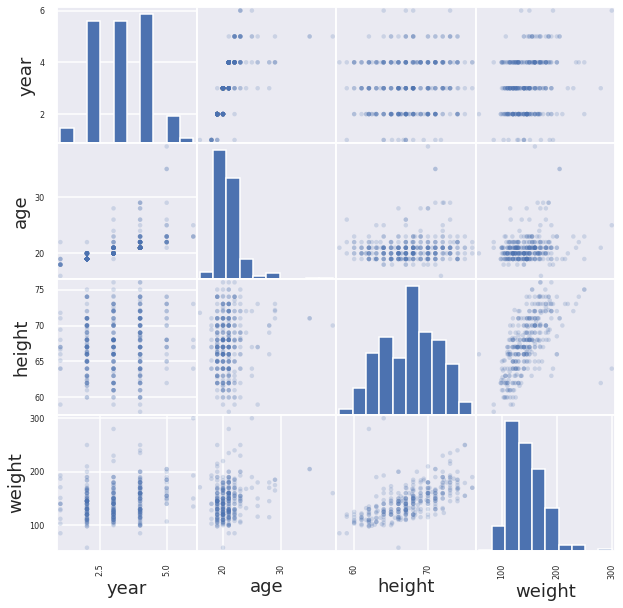

In [49]:
# your code here
fig = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = (10,10))

In [50]:
assert np.all(fig)

### 2b) Plot a bar chart showing the number of students in each major. 

Hint: 
- if using `seaborn`, you're looking to make a countplot
- if using pandas, you can use `value_counts` to get the counts for each major. You can then use the `plot` method from `pandas` for plotting (You don't need `matplotlib`). 


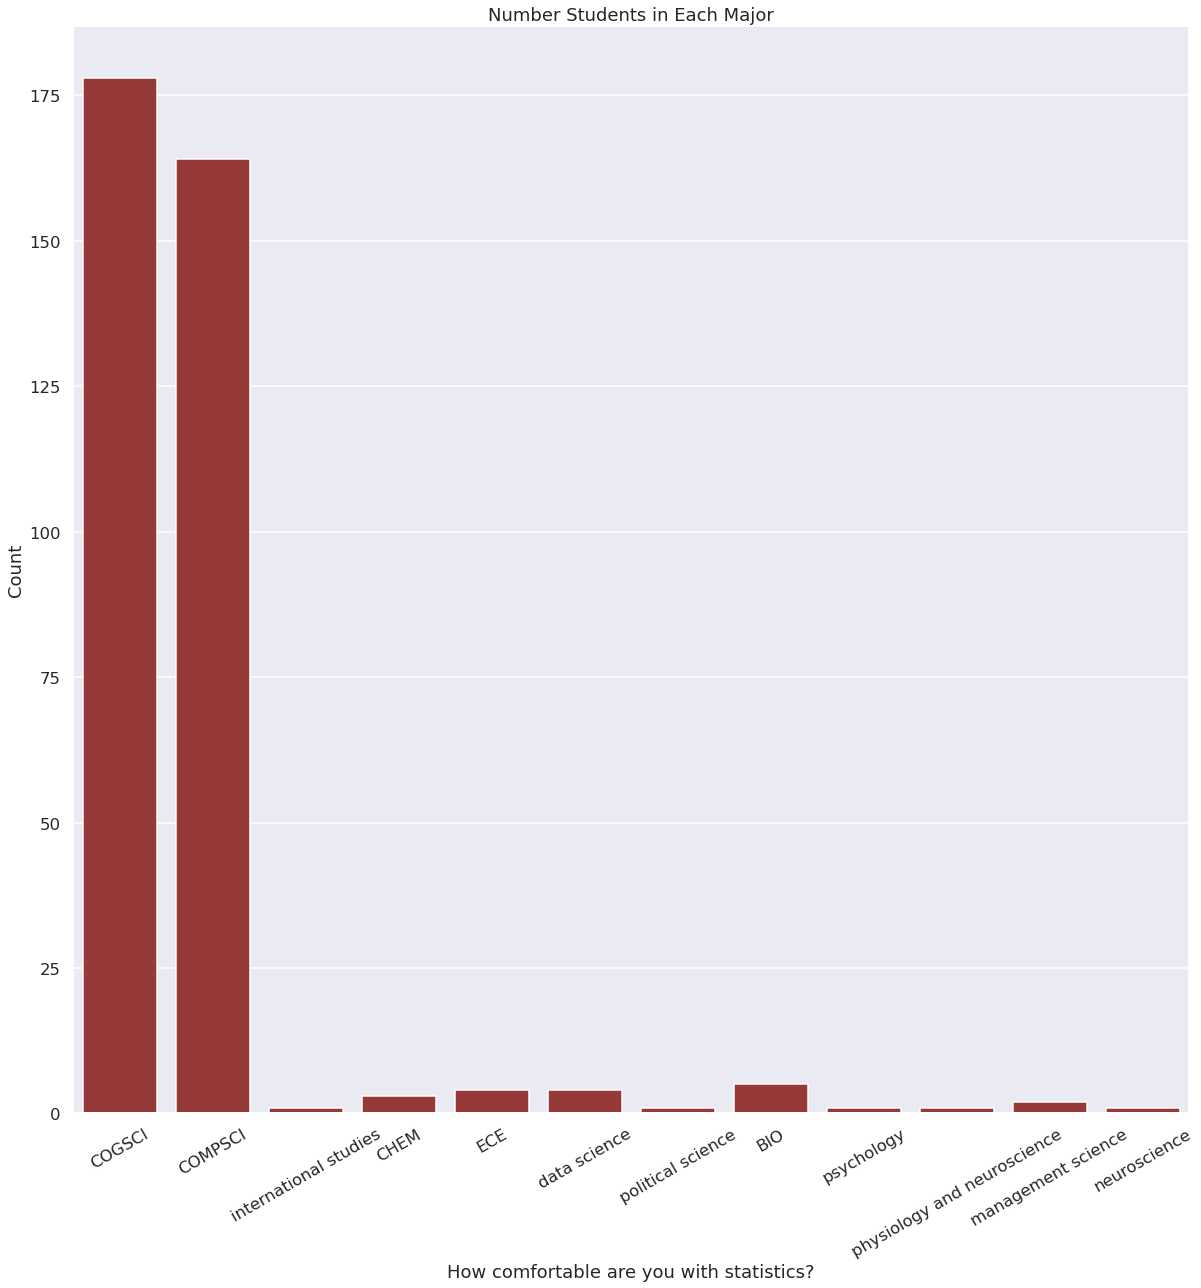

In [51]:
# your code here
plt.rcParams['figure.figsize'] = (20,20)
ax = sns.countplot(x='major', data=df, color = 'brown')



# add title and axis labels (modify x-axis label)
#add title: 
ax.set_title('Number Students in Each Major')
#add y label 
ax.set_ylabel('Count')
#add x label 
ax.set_xlabel('How comfortable are you with statistics?');
ax.tick_params(axis='x', rotation=30)

f1 = plt.gcf()

In [52]:
assert f1.gca().has_data()

### 2c) Plot a histogram of the height data for all students who wrote 'COGSCI' as their major.


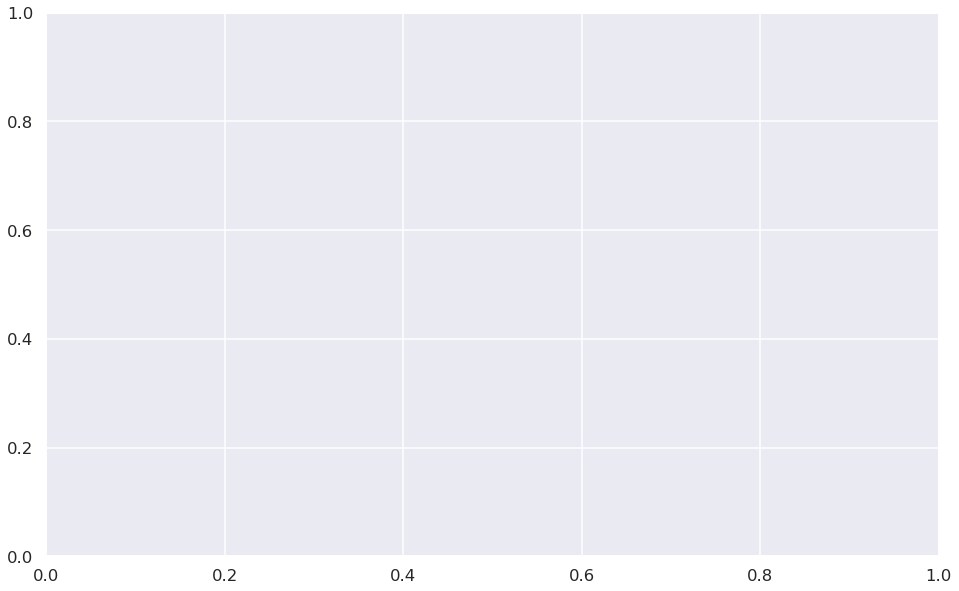

In [53]:
# your code here
plt.rcParams['figure.figsize'] = (16,10) #default plot size to output

data1 = df[df['height'] == 'COGSCI']
sns.histplot(data = data1, bins=30)
#sns.histplot(data = [df['height'] == 'COGSCI'], bins=30)

f2 = plt.gcf()

In [54]:
assert f2.gca().has_data()

AssertionError: 

### 2d) Plot a histogram of the height data for all students who wrote 'COMPSCI' as their major.


In [ ]:
#START CODE 
#Plot a histogram of the height data for all students who wrote 'COMPSCI' as their major.
#lecturec3
#df['statistics'].hist();
#val = df[(df.major == 'COMPSCI')]['height']
(df['major'] == 'COMPSCI')['height'].hist()

#sns.histplot(df['statistics'], bins=10, kde=False);

#END CODE 
f3 = plt.gcf()

In [ ]:
assert f3.gca().has_data()

## Part 3: Exploring The Data (0.4 points)

Beyond just plotting the data, we should check some other basic properties of the data. This serves both as a way to get a 'feel' for the data, and to look for any quirks or oddities about the data, that may indicate issues that need resolving. To do this, let's explore that data a bit (not limiting ourselves to only features that we plan to use - exploring the dataset as a whole can help us find any issues). 

Notes:
- Your answers should NOT be pandas objects (Series or DataFrames), extract answers so the variables are ints, floats or strings (as appropriate).
- You must answer these questions programmatically: do not count / check and hard code particular values.

### 3a) How many different majors are in the dataset?

Calculate this programmatically, and save this number to a variable `n_majors`.

In [ ]:
#START CODE 
#lost of 'unique' majors 
#n_majors = df['major'].unique()
#n_majors

n_majors = df['major'].nunique()
#check:
#n_majors
#END CODE 

In [ ]:
assert n_majors > 0 and n_majors < 25

### 3b) What is the range (max value - min value) of ages in the dataset?

Calculate this programmatically and save this number to a variable `r_age`.

In [ ]:
#START CODE
r_age = df['age'].max() - df['age'].min()
r_age 
#END CODE 

In [ ]:
assert r_age > 0 and r_age < 50

## Part 4: Data Analysis (4.15 points)

Now let's analyze the data, to address our research question.

For the purposes of this analysis, let's assume we need at least 75 students per major to analyze the height data. 

This means we are only going to use data from people who wrote 'COGSCI' or 'COMPSCI' as their major. 


### 4a) Pull out the data we are going to use:

Save the height data for all 'COGSCI' majors to a variable called `h_co`

Save the height data for all 'COMPSCI' majors to a variable called `h_cs`

In [ ]:
# START CODE 
#from D6:
#h_france = df[df['nationality'] == 'France']['height']

#only include major column with 'cogsci' only. save only the height values and store in h_co
h_co = df[(df.major == 'COGSCI')]['height']
h_cs = df[(df.major == 'COMPSCI')]['height']

#check test
#len(h_co)
#len(h_cs)
#END CODE 

In [ ]:
assert np.all(h_co)
assert np.all(h_cs)

assert len(h_co) == 178
assert len(h_cs) == 164

In [ ]:
#stat details of cogsci majors 
h_co.describe()

In [ ]:
h_cs.describe()

### 4b) What is the average (mean) height for students from each major?

Calulate this programmatically and save these values to `avg_h_co` for COGSCI students, and `avg_h_cs` for COMPSCI students. 


In [ ]:
#START CODE 
avg_h_co = h_co.agg('mean')
avg_h_cs = h_co.agg('mean')
#END CODE 

In [ ]:
assert avg_h_co
assert avg_h_cs

In [ ]:
# Print out the average heights - this code provided
print('Average height of cogs majors is \t {:2.2f} inches'.format(avg_h_co))
print('Average height of cs majors is \t\t {:2.2f} inches'.format(avg_h_cs))

Based on the cell above, it looks like there might indeed be a difference in the average height for students in cogs vs cs majors. 

Now we want to statistically test this difference. To do so, we will use a t-test. 

### 4c) Compare distributions: t-test 

Use the `ttest_ind` function) to compare the two height distributions (`h_co` vs `h_cs`)

`ttest_ind` returns a t-statistic, and a p-value. Save these outputs to `t_val` and `p_val` respectively. 


In [ ]:
#START CODE 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
t_val, p_val = stats.ttest_ind(h_co, h_cs)


#END CODE 

In [ ]:
assert t_val
assert p_val

In [ ]:
# Check if statistical test passes significance, using an alpha value of 0.01. This code provided.
if p_val < 0.01:
    print('Data Science accomplished, there is a significant difference!')
else:
    print('There is NOT a significant difference!')
    
# Editorial note:
#  Chasing significant p-values as the goal itself is not actually a good way to do data (or any) science :)

Note: this test *should* pass significance. If it doesn't, double check your code up until this point.

So - we've reached a conclusion! We're done right!?

Nope. We have a first pass analysis, and an interim conclusion that happens to follow our hypothesis. 

Now let's try to break it. 

#### Let's explore some more

You should always interrogate your findings, however they come out. What could be some alternate explanations, that would change our interpretations of the current analysis?

In this case, we should be worried about confounding variables. We want to be able to say whether height relates to major specifically, but it could be the case that some other variable, that happens to differ between majors, better explains the differences in height. 

In this case, we also have data on gender. Let's check if differences in the gender ratio of the two majors can explain the difference in height. 

### 4d) Digging Deeper

Using `value_counts` from pandas, extract the number of 'male', 'female', and 'nonbinary_or_trans' individuals, separately for cogs and cs students. 

To do so:

- select from the `df` each major, separately, extract the gender column, and use the `value_counts` method.
- Save the counts for each gender for 'COGSCI' majors to a variable called `g_co`
-  Save the counts for each gender for 'COMPSCI' majors to a variable called `g_cs`


In [ ]:
#START CODE 
#Save the counts for each gender for 'COGSCI' majors to a variable called g_co
g_co = df[(df.major == 'COGSCI')]['gender'].value_counts()
#Save the counts for each gender for 'COMPSCI' majors to a variable called g_cs
g_cs = df[(df.major == 'COMPSCI')]['gender'].value_counts()
#END CODE

In [ ]:
assert np.all(g_co)
assert np.all(g_cs)

assert g_co[0] == 91
assert g_cs[1] == 38
assert g_cs[2] == 1

### 4e) What is the ratio of women in each major? 

By ratio, we mean the proportion of students that are female, as a ratio. This will be a value between 0.0 and 1.0, calculated as #F / (#F + #M + #nonbinary_or_other) - done separately for each major

You can use the `g_co` and `g_cs` variables to calculate these.

Save the ratio of women in COGSCI to a variable `r_co`.

Save the ratio of women in COMPSCI to a variable `r_cs`.

Note: keep these numbers as ratios (they should be decimal numbers, less than 1).


In [ ]:
#START CODE 
#Save the ratio of women in COGSCI to a variable `r_co`.
r_co = g_co['female']
#Save the ratio of women in COMPSCI to a variable `r_cs`.
r_cs = g_cs['female']
#END CODE

In [ ]:
assert r_co
assert r_cs

Make sure you print out and check the values of these ratios. They seem pretty different.

We can actually ask, using a chi-squared test, whether this difference in gender-ratio between the majors is signficantly different.

Code to do this is provided below. 

Run a chi-squared test of the difference of ratios of categorical data between groups:


In [ ]:
chisq, p_val_chi = stats.chisquare(np.array([g_co.values, g_cs.values]), axis=None)

if p_val_chi < 0.01:
    print('There is a significant difference in ratios!')

### 4f) Subsetting data

Create a new dataframe, called `df2`, which only includes data from 'COGSCI' and 'COMPSCI' majors.

Hint: you can do this using the or operater '|', with loc. 


In [ ]:
# your code here
df2 = df[(df['major'] == 'COGSCI') | (df['major'] == 'COMPSCI')]
#df2.reset_index()

In [ ]:
assert isinstance(df2, pd.DataFrame)
assert df2.shape == (342, 10)
assert set(df2['major']) == set(['COGSCI', 'COMPSCI'])

### 4g) Pivot Tables

Another way to look at these kinds of comparisons is pivot tables. 

Use the pandas `pivot_table` method to create a pivot table, assign it to a variable `pv`.

Set the values as 'height', and the indices as 'gender' and 'major' in the pivot table.

Make sure you do this using `df2`. 


In [ ]:
#START CODE 
#https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html
pv = df2.pivot_table(values = 'height', index = ['gender', 'major'])
#END CODE 

In [ ]:
assert np.all(pv)
assert isinstance(pv.index, pd.MultiIndex)

Print out the pivot table you just created. 

Compare the average height values, split up by major and gender.

Does it look like there are differences in heights by major, when spit up by gender?


In [ ]:
pv

Let's recap where we are:
- Our initial hypothesis suggested there is a significant difference between heights of people in different majors. 
- However, further analyses suggested there may be a confounding variable, as there is also a significantly different gender balance between majors. 

Checking the average height, per major, split up by gender, suggests there may not be a difference between major, other than what is explained by gender. 

Now we want to statistically ask this question: is there still a difference in height between majors, when controlling for differences in gender?

#### Linear Models

For the following question you will need to make some linear models, using Ordinary Least Squares (OLS).

There is more than one way to do this in Python. For the purposes of this assignment, you must use the method that is outlined in the 'LinearModels' Tutorial, using patsy, and statsmodels. 

That is: 
- Create design matrices with `patsy.dmatrices`
- Initialize an OLS model with `sm.OLS`
- Fit the OLS model
- Check the summary for results. 

### 4h) Linear model

Create a linear model to predict height from major (using `df2` as data).

Use `patsy.dmatrices` to create the design matrices, calling the outputs `outcome_1`, `predictors_1`.

Create an OLS model (`sm.OLS`) using `outcome_1` and `predictors_1`. Call it `mod_1`.

Fit the model, assigning it to `res_1`.

In [ ]:
#START CODE 
#create the design matrices 
outcome_1, predictors_1 = patsy.dmatrices('height ~ major', df2)
#create the OLS model 
mod_1 = sm.OLS(outcome_1, predictors_1)
#fit the model 
res_1 = mod_1.fit()

#END CODE 

In [ ]:
assert isinstance(outcome_1, patsy.design_info.DesignMatrix)
assert isinstance(predictors_1, patsy.design_info.DesignMatrix)
assert isinstance(mod_1, sm.regression.linear_model.OLS)
assert isinstance(res_1, sm.regression.linear_model.RegressionResultsWrapper)

In [ ]:
# Print out the summary results of the model fitting
print(res_1.summary())

### 4i) Assess significance: `mod_1`

Based on the model you ran above (using alpha value of 0.01), does major significantly predict height?

Set your answer as a boolean (True / False) to a variable called `lm_1`.

In [ ]:
#START CODE 
# "If the P-value is less than or equal to the significance level, we reject the null hypothesis
#and accept the alternative hypothesis instead. If the P-value is greater 
#than the significance level, we say we “fail to reject” the null hypothesis"

#https://courses.lumenlearning.com/wm-concepts-statistics/chapter/introduction-to-hypothesis-testing-5-of-5/#:~:text=If%20the%20P%2Dvalue%20is,to%20reject%E2%80%9D%20the%20null%20hypothesis.
alpha_value = 0.01

if p_val <= alpha_value:
    lm_1 = False
    print(lm_1)
else: 
    lm_1 = True 
    print(lm_1)
#END CODE 

In [ ]:
assert isinstance(lm_1, bool)

### 4j) Multivariate regression

Create a linear model to predict height from both major and gender (using `df2` as data).

Use `patsy.dmatrices` to create the design matrices, calling the outputs `outcome_2`, `predictors_2`

Create an OLS model (`sm.OLS`) using `outcome_2` and `predictors_2`.  Call it `mod_2`.

Fit the model, assigning it to `res_2`.


In [ ]:
#START CODE 

#create the design matrices 
outcome_2, predictors_2 = patsy.dmatrices('height ~ major + gender', df2)
#create the OLS model 
mod_2 = sm.OLS(outcome_2, predictors_2)
#fit the model 
res_2 = mod_2.fit()

#END CODE 

In [ ]:
assert isinstance(outcome_2, patsy.design_info.DesignMatrix)
assert isinstance(predictors_2, patsy.design_info.DesignMatrix)
assert isinstance(mod_2, sm.regression.linear_model.OLS)
assert isinstance(res_2, sm.regression.linear_model.RegressionResultsWrapper)

In [ ]:
# Print out the results 
print(res_2.summary())

### 4k) Assess significance: `mod_2`

Based on the model you ran above (using alpha value of 0.01), does major significantly predict height?

Set your answer as a boolean (True / False) to a variable called `lm_2`

In [ ]:
#START CODE 
alpha_value = 0.01

if p_val <= alpha_value:
    lm_2 = False
    print(lm_2)
else: 
    lm_2 = True 
    print(lm_2)
#END CODE 

In [ ]:
assert isinstance(lm_2, bool)

## Part 5: Discussion & Conclusions (0.15 points)

### 5a) Conclusion

Set a boolean variable, called `ans`, as True or False as the answer to the following statement:

We have evidence supporting our research hypothesis:

> People in different majors have systematically different heights (and this difference can be tied to their major).


In [ ]:
# your code here
ans = False

In [ ]:
assert isinstance(ans, bool)

### 5b) Summary

Write a short response (1-2 sentence) summarizing the results.

Did we support our hypothesis? Why or why not? What turned out to be the finding(s)?

We originally hypothesized that there will be a relation between height and chosen major; yet, we concluded that there was no relationship. The findings were that there indeed is no relationship because we had to reject the null hypothesis. 

#We did not support our hypothesis, as one can note, the p_value for the linear model to predict height from major was 0.001. Now because 0.001 is smaller than 0.01, we have to reject the null. Subsequently, the p_value for the linear model to predict height from both major and gender was also smaller than 0.01 (as one can note below). Thus, the findings was that there is no relation ebwteen height and a chosen major. Furthermore, we can see females are shorter in height compared to males in both cogsci and compsci majors. Yet, nonbinary or transgender individuals were somewhat between female and male genders. Intuitively, this makes sense because females do tend to be shorter than males. 

In [ ]:
p_val

In [ ]:
pv

## The End!

Good work! Have a look back over your answers, and also make sure to `Restart & Run All` from the kernel menu to double check that everything is working properly. You can also use the 'Validate' button above, which runs your notebook from top to bottom and checks to ensure all `assert` statements pass silently. When you are ready, submit on datahub!